# Derivation of effective spin-$\frac{1}{2}$ Hamiltonian for LiHoF<sub>4</sub>
### Performs projection of angular momentum operators onto the low energy subspace spanned by the Ho ion's 2 lowest-energy electronic states under the LiHoF<sub>4</sub> crystal field potential and an applied magnetic field in the x-direction
Based on Chakraborty et al. \[1\] and explained in more detail by Tabei et al. \[2\].

\[1\] P. B. Chakraborty, P. Henelius, H. Kjønsberg, A. W. Sandvik, and S. M. Girvin, Theory of the Magnetic Phase Diagram of Li Ho F 4, [Phys. Rev. B 70, 144411](https://link.aps.org/doi/10.1103/PhysRevB.70.144411) (2004).\
\[2\] S. M. A. Tabei, M. J. P. Gingras, Y.-J. Kao, and T. Yavors’kii, Perturbative Quantum Monte Carlo Study of LiHoF 4 in a Transverse Magnetic Field, [Phys. Rev. B 78, 184408](https://link.aps.org/doi/10.1103/PhysRevB.78.184408) (2008).


In [1]:
import numpy as np
from numpy import linalg as LA
from scipy.sparse import linalg as sLA
import matplotlib.pyplot as plt
import math

In [2]:
#constants
hbar = 1
J=8
deg_J = 2 * J + 1
g_L = 5/4 # Lande g-factor
u_B = 0.6717 # Bohr magneton

In [3]:
# J matrices
jplus = hbar * np.diag(np.array( [ math.sqrt(J*(J+1) - m*(m+1)) for m in np.arange(-J,J) ] ), 1)
jminus = hbar * np.diag(np.array( [ math.sqrt(J*(J+1) - m*(m-1)) for m in np.arange(-J+1,J+1) ] ),-1)
jx = (jplus + jminus) * 0.5
jy = (jplus - jminus) * (-0.5j)
jz = hbar * np.diag(np.arange(-J,J+1))
I_J = np.diag(np.ones(int(round(deg_J))))

In [4]:
# crystal field equivalent operators
O02 = 3 * LA.matrix_power(jz,2) - J*(J+1)*I_J
O04 = 35 * LA.matrix_power(jz,4) - 30 * J * (J+1) * LA.matrix_power(jz,2) + 25*LA.matrix_power(jz,2) - 6 * J * (J+1) * I_J + 3 * J**2 * (J+1)**2 * I_J
O44C = 0.5 * (LA.matrix_power(jplus,4) + LA.matrix_power(jminus,4))
O06 = 231 * LA.matrix_power(jz,6) - 315*J*(J+1)*LA.matrix_power(jz,4) + 735*LA.matrix_power(jz,4) + 105 * J**2 * (J+1)**2 * LA.matrix_power(jz,2) - 525*J*(J+1)*LA.matrix_power(jz,2) + 294*LA.matrix_power(jz,2) - 5 * J**3 * (J+1)**3 * I_J + 40 * J**2 *(J+1)**2 * I_J - 60*J*(J+1)*I_J
O46C1 = 0.25 * (LA.matrix_power(jplus,4) + LA.matrix_power(jminus,4)) @ (11*LA.matrix_power(jz,2) - J*(J+1)*I_J - 38*I_J)
O46S1 = -0.25j * (LA.matrix_power(jplus,4) - LA.matrix_power(jminus,4)) @ (11 * LA.matrix_power(jz,2) - J*(J+1)*I_J - 38*I_J)
O46C = O46C1 + np.transpose(np.conj(O46C1))
O46S = O46S1 + np.transpose(np.conj(O46S1))

In [5]:
# crystal field parameters
B02 = -0.696
B04 = 4.06e-3
B06 =  4.64e-6
B44C = 0.0418
B46C = 8.12e-4
B46S = 1.137e-4

In [6]:
# crystal field Hamiltonian
H_cf = B02*O02 + B04*O04 + B06*O06 + B44C*O44C + B46C*O46C + B46S*O46S

## Only Bx varies (same as in references)

In [22]:
# Magnetic field Zeeman term
Bx = np.linspace(0.0,5.0, num=100)
Bx=Bx+0.0
By = 0
Bz=0

H_zeeman = [ -g_L * u_B * (Bx[i]*jx + By*jy + Bz*jz) for i in range(len(Bx)) ]

In [23]:
# full Hamiltonian
H = [ ( H_cf + H_zeeman_x )for H_zeeman_x in H_zeeman ]

H=np.array(H)
assert np.allclose(H.transpose(0,2,1).conj(), H) # check Hermiticity

In [ ]:
## there is a problem with this calculation I could not pin down. Use the next cell instead.

# diagonalization
res=[]
eigen_energies=[]
for i, h in enumerate(H):
    w,v = LA.eigh(h)
    res.append(v.T)
    eigen_energies.append(w)

eigenstates=np.array(res)

#print(eigenstates[0])
for i, bx in enumerate(Bx):
    alpha = eigenstates[i, 0, :]
    beta = eigenstates[i, 1, :]
#     print(np.conj(np.transpose(beta)) @ alpha)
#     print("Bx=" + str(bx) + ", energy="+str(beta))
#     print("Bx=" + str(bx) + ", energy="+str(eigen_energies[i][0]*alpha - H[i] @ alpha))
    print("beta@jz@beta="+str(np.conj(np.transpose(beta)) @ jz @ beta))
    print("alpha@jz@alpha="+str(np.conj(np.transpose(alpha)) @ jz @ alpha))
    print("alpha@jz@beta="+str(np.conj(np.transpose(alpha)) @ jz @ beta))
    print("beta@jz@alpha="+str(np.conj(np.transpose(beta)) @ jz @ alpha))
    theta=np.angle(np.conj(np.transpose(beta)) @ jz @ alpha)
    print('%s : %s'%(bx, theta))
    eigenstates[i, 1, :] = (alpha + np.exp(1j*theta)*beta)/math.sqrt(2)
    eigenstates[i, 0, :] = (alpha - np.exp(1j*theta)*beta)/math.sqrt(2)
    up = eigenstates[i, 0, :]
    down = eigenstates[i, 1, :]
    print('up='+str(up))
    print('down='+str(down))
    print("down@jz@down="+str(np.conj(np.transpose(down)) @ jz @ down))
    print("up@jz@up="+str(np.conj(np.transpose(up)) @ jz @ up))
    print("up@jz@down="+str(np.conj(np.transpose(up)) @ jz @ down))
    print("down@jz@up="+str(np.conj(np.transpose(down)) @ jz @ up))

#print(eigenstates[0])
# 1st index is H, 2nd index is eigenvalue number (from lowest to highest)
change_of_basis_matrix_inverse=np.transpose(eigenstates,axes=(0,2,1))
change_of_basis_matrix=LA.inv(change_of_basis_matrix_inverse)
new_jz=change_of_basis_matrix @ jz @ change_of_basis_matrix_inverse
new_jx=change_of_basis_matrix @ jx @ change_of_basis_matrix_inverse
new_jy=change_of_basis_matrix @ jy @ change_of_basis_matrix_inverse

#print(new_jz)

upjzup=[]
downjzdown=[]
upjxup=[]
downjxdown=[]
upjyup=[]
downjydown=[]
upjzdown=[]
downjzup=[]
upjxdown=[]
downjxup=[]
upjydown=[]
downjyup=[]

for c in range(eigenstates.shape[0]):
    upjzup.append(new_jz[c,0,0])    
    downjzdown.append(new_jz[c,1,1])
    upjxup.append(new_jx[c,0,0])
    downjxdown.append(new_jx[c,1,1])
    upjyup.append(new_jy[c,0,0])
    downjydown.append(new_jy[c,1,1])
    upjzdown.append(new_jz[c,0,1])
    downjzup.append(new_jz[c,1,0])
    upjxdown.append(new_jx[c,0,1])
    downjxup.append(new_jx[c,1,0])
    upjydown.append(new_jy[c,0,1])
    downjyup.append(new_jy[c,1,0])
    

upjzup=np.array(upjzup)
downjzdown=np.array(downjzdown)
upjxup=np.array(upjxup)
downjxdown=np.array(downjxdown)
upjyup=np.array(upjyup)
downjydown=np.array(downjydown)
upjzdown=np.array(upjzdown)
downjzup=np.array(downjzup)
upjxdown=np.array(upjxdown)
downjxup=np.array(downjxup)
upjydown=np.array(upjydown)
downjyup=np.array(downjyup)
plt.close()
#plt.plot(Bx,0.5*(eigenvalues[:,1]-eigenvalues[:,0]))
plt.figure(figsize=(12,8))
plt.plot(Bx,0.5*(upjzup-downjzdown),label=r'$C_{zz}$')
plt.plot(Bx,0.5*(upjzup+downjzdown),label=r'$C_{z0}$')
plt.plot(Bx,0.5*(upjzdown+downjzup),label=r'$C_{zx}$')
# plt.plot(Bx,upjzdown,label='upjzdown')
# plt.plot(Bx,downjzup,label='downjzup')
plt.plot(Bx,-0.5j*(upjzdown-downjzup),label=r'$C_{zy}$')
plt.plot(Bx,0.5*(upjxup+downjxdown),label=r'$C_{x0}$')
plt.plot(Bx,-0.5j*(upjydown-downjyup),label=r'$C_{yy}$')
plt.plot(Bx,0.5*(upjxdown+downjxup),label=r'$C_{xx}$')

#np.set_printoptions(precision=5)
#np.set_printoptions(suppress=True)
#print(new_jz)
#print(part_new_jx[:,:,0])
plt.legend()
plt.xlabel(r'$B_x$')
plt.ylabel(r'$C_{\mu\nu}$')
plt.show()

In [ ]:
### diagonalization
res=[]
eigen_energies=[]
for i, h in enumerate(H):
    w,v = LA.eigh(h)
    res.append(v.T)
    eigen_energies.append(w)

eigenstates1=np.array(res)
# 1st index is H, 2nd index is eigenvalue number (from lowest to highest)
change_of_basis_matrix_inverse=np.transpose(eigenstates1,axes=(0,2,1))
change_of_basis_matrix=LA.inv(change_of_basis_matrix_inverse)
new_jz=change_of_basis_matrix @ jz @ change_of_basis_matrix_inverse
new_jx=change_of_basis_matrix @ jx @ change_of_basis_matrix_inverse
new_jy=change_of_basis_matrix @ jy @ change_of_basis_matrix_inverse

# print(np.matrix(new_jz))

part_new_jz=np.array(((new_jz[:,0,0],new_jz[:,0,1]),(new_jz[:,1,0],new_jz[:,1,1])))
part_new_jx=np.array(((new_jx[:,0,0],new_jx[:,0,1]),(new_jx[:,1,0],new_jx[:,1,1])))
part_new_jy=np.array(((new_jy[:,0,0],new_jy[:,0,1]),(new_jy[:,1,0],new_jy[:,1,1])))

eigenvalues=[]
eigenstates=[]

j=0
for part_new_jz_i in part_new_jz.transpose(2,0,1):
#     print("part_new_jz_i")
#     print(part_new_jz_i)
    w1,v1 = LA.eigh(part_new_jz_i)
    eigenvalues.append(w1)
#     print('Bx='+str(Bx[j]))
#     j+=1
    for i in range(v1.T[:,0].size):
        v1.T[i,:]*=np.exp(-1j*np.angle(v1.T[i,0]))
#     print(np.angle(v1.T))
#     print(np.abs(v1.T))
    eigenstates.append(v1)

    
# # checks:
# alpha = eigenstates1[0, 0, :]
# beta = eigenstates1[0, 1, :]
# up_coord=v1[:,0]
# down_coord=v1[:,1]
# print('up_coord='+str(np.angle(up_coord)))
# print('down_coord='+str(np.angle(down_coord)))
# up=up_coord[0]*alpha + up_coord[1]*beta
# down=down_coord[0]*alpha + down_coord[1]*beta
# print('up='+str(up))
# print('down='+str(down))
# print("up@down="+str(np.conj(np.transpose(up)) @ down))
# # print("up@jz@down="+str(np.conj(np.transpose(up)) @ jz @ down))
# # print("down@jz@up="+str(np.conj(np.transpose(down)) @ jz @ up))
# # print("down@jz@down="+str(np.conj(np.transpose(down)) @ jz @ down))
# # print("up@jz@up="+str(np.conj(np.transpose(up)) @ jz @ up))
    
eigenvalues=np.array(eigenvalues)
eigenstates=np.array(eigenstates)

upjzup=[]
downjzdown=[]
upjxup=[]
downjxdown=[]
upjyup=[]
downjydown=[]
upjzdown=[]
downjzup=[]
upjxdown=[]
downjxup=[]
upjydown=[]
downjyup=[]

for c in range(eigenstates.shape[0]):
    upjzup.append(np.conj(eigenstates[c,:,0].T) @ part_new_jz.transpose(2,0,1)[c] @ eigenstates[c,:,0])
    downjzdown.append(np.conj(eigenstates[c,:,1].T) @ part_new_jz.transpose(2,0,1)[c] @ eigenstates[c,:,1])
    upjxup.append(np.conj(eigenstates[c,:,0].T) @ part_new_jx.transpose(2,0,1)[c] @ eigenstates[c,:,0])
    downjxdown.append(np.conj(eigenstates[c,:,1].T) @ part_new_jx.transpose(2,0,1)[c] @ eigenstates[c,:,1])
    upjyup.append(np.conj(eigenstates[c,:,0].T) @ part_new_jy.transpose(2,0,1)[c] @ eigenstates[c,:,0])
    downjydown.append(np.conj(eigenstates[c,:,1].T) @ part_new_jy.transpose(2,0,1)[c] @ eigenstates[c,:,1])
    upjzdown.append(np.conj(eigenstates[c,:,0].T) @ part_new_jz.transpose(2,0,1)[c] @ eigenstates[c,:,1])
    downjzup.append(np.conj(eigenstates[c,:,1].T) @ part_new_jz.transpose(2,0,1)[c] @ eigenstates[c,:,0])
    upjxdown.append(np.conj(eigenstates[c,:,0].T) @ part_new_jx.transpose(2,0,1)[c] @ eigenstates[c,:,1])
    downjxup.append(np.conj(eigenstates[c,:,1].T) @ part_new_jx.transpose(2,0,1)[c] @ eigenstates[c,:,0])
    upjydown.append(np.conj(eigenstates[c,:,0].T) @ part_new_jy.transpose(2,0,1)[c] @ eigenstates[c,:,1])
    downjyup.append(np.conj(eigenstates[c,:,1].T) @ part_new_jy.transpose(2,0,1)[c] @ eigenstates[c,:,0])

upjzup=np.array(upjzup)
downjzdown=np.array(downjzdown)
upjxup=np.array(upjxup)
downjxdown=np.array(downjxdown)
upjyup=np.array(upjyup)
downjydown=np.array(downjydown)
upjzdown=np.array(upjzdown)
downjzup=np.array(downjzup)
upjxdown=np.array(upjxdown)
downjxup=np.array(downjxup)
upjydown=np.array(upjydown)
downjyup=np.array(downjyup)
plt.close()
#plt.plot(Bx,0.5*(eigenvalues[:,1]-eigenvalues[:,0]))
plt.figure(figsize=(12,8))
plt.plot(Bx,0.5*abs(upjzup-downjzdown),label=r'$C_{zz}$')
plt.plot(Bx,0.5*(upjxup+downjxdown),label=r'$C_{x0}$')
plt.plot(Bx,0.5j*(upjydown-downjyup),label=r'$C_{yy}$')
plt.plot(Bx,0.5*(upjxdown+downjxup),label=r'$C_{xx}$')
plt.plot(Bx,0.5*(upjzup+downjzdown),label=r'$C_{z0}$')
plt.plot(Bx,0.5*(upjzdown+downjzup),label=r'$C_{zx}$')
plt.plot(Bx,-0.5j*(upjzdown-downjzup),label=r'$C_{zy}$')
plt.plot(Bx,0.5*(upjxup-downjxdown),label=r'$C_{xz}$')
plt.plot(Bx,upjzdown,label=r'$upjzdown$')

# np.set_printoptions(precision=3)
# np.set_printoptions(suppress=True)
#print(downjxup)
#print(part_new_jx[:,:,0])
plt.legend()
plt.xlabel(r'$B_x$')
plt.ylabel(r'$C_{\mu\nu}$')
plt.show()

## Both Bx and By vary (test used in the simulation)

In [40]:
# Magnetic field Zeeman term
Bx = np.linspace(-2.0,5.0, num=81)
Bx=Bx+0.0
By = np.linspace(-2.0,2.0, num=81)
Bz=0

H_zeeman = [[ -g_L * u_B * (Bx[i]*jx + By[j]*jy + Bz*jz) for i in range(len(Bx)) ] for j in range(len(By))]

In [41]:
# full Hamiltonian
H = [ [( H_cf + H_zeeman_xy ) for H_zeeman_xy in H_zeeman_x ] for H_zeeman_x in H_zeeman ]

H=np.array(H)
assert np.allclose(H.transpose(0,1,3,2).conj(), H) # check Hermiticity

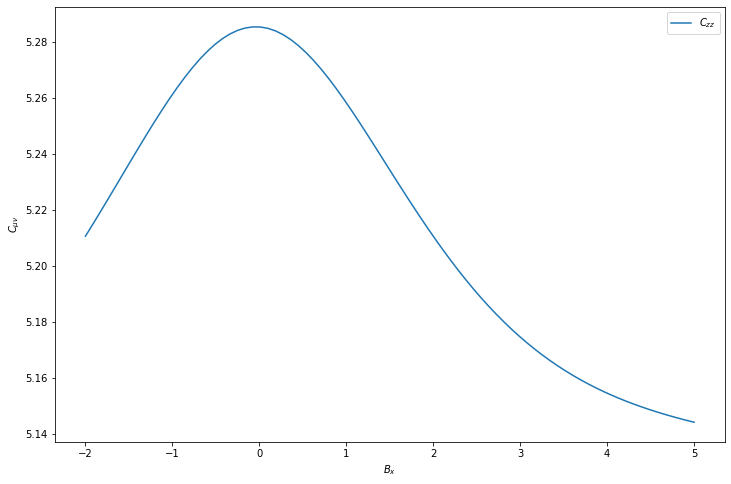

In [42]:
### diagonalization
res=[]
eigen_energies=[]
for hx in H:
    res_x=[]
    eigen_energies_x=[]
    for hxy in hx:
        w,v = LA.eigh(hxy)
        res_x.append(v.T)
        eigen_energies_x.append(w)
    res.append(res_x)
    eigen_energies.append(eigen_energies_x)

eigenstates1=np.array(res)
# 1st index is H, 2nd index is eigenvalue number (from lowest to highest)
change_of_basis_matrix_inverse=np.transpose(eigenstates1,axes=(0,1,3,2))
change_of_basis_matrix=LA.inv(change_of_basis_matrix_inverse)
new_jz=change_of_basis_matrix @ jz @ change_of_basis_matrix_inverse
new_jx=change_of_basis_matrix @ jx @ change_of_basis_matrix_inverse
new_jy=change_of_basis_matrix @ jy @ change_of_basis_matrix_inverse

# print(np.matrix(new_jz))

part_new_jz=np.array(((new_jz[:,:,0,0],new_jz[:,:,0,1]),(new_jz[:,:,1,0],new_jz[:,:,1,1])))
part_new_jx=np.array(((new_jx[:,:,0,0],new_jx[:,:,0,1]),(new_jx[:,:,1,0],new_jx[:,:,1,1])))
part_new_jy=np.array(((new_jy[:,:,0,0],new_jy[:,:,0,1]),(new_jy[:,:,1,0],new_jy[:,:,1,1])))

eigenvalues=[]
eigenstates=[]

j=0
for part_new_jz_i in part_new_jz.transpose(2,3,0,1):
    eigenvalues_i=[]
    eigenstates_i=[]
    for part_new_jz_ij in part_new_jz_i:
#     print("part_new_jz_i")
#     print(part_new_jz_i)
        w1,v1 = LA.eigh(part_new_jz_ij)
        eigenvalues_i.append(w1)
#     print('Bx='+str(Bx[j]))
#     j+=1
        for i in range(v1.T[:,0].size):
            v1.T[i,:]*=np.exp(-1j*np.angle(v1.T[i,0]))
#     print(np.angle(v1.T))
#     print(np.abs(v1.T))
        eigenstates_i.append(v1)
    eigenstates.append(eigenstates_i)
    eigenvalues.append(eigenvalues_i)

    
# # checks:
# alpha = eigenstates1[0, 0, :]
# beta = eigenstates1[0, 1, :]
# up_coord=v1[:,0]
# down_coord=v1[:,1]
# print('up_coord='+str(np.angle(up_coord)))
# print('down_coord='+str(np.angle(down_coord)))
# up=up_coord[0]*alpha + up_coord[1]*beta
# down=down_coord[0]*alpha + down_coord[1]*beta
# print('up='+str(up))
# print('down='+str(down))
# print("up@down="+str(np.conj(np.transpose(up)) @ down))
# # print("up@jz@down="+str(np.conj(np.transpose(up)) @ jz @ down))
# # print("down@jz@up="+str(np.conj(np.transpose(down)) @ jz @ up))
# # print("down@jz@down="+str(np.conj(np.transpose(down)) @ jz @ down))
# # print("up@jz@up="+str(np.conj(np.transpose(up)) @ jz @ up))
    
eigenvalues=np.array(eigenvalues)
eigenstates=np.array(eigenstates)

upjzup=[]
downjzdown=[]
upjxup=[]
downjxdown=[]
upjyup=[]
downjydown=[]
upjzdown=[]
downjzup=[]
upjxdown=[]
downjxup=[]
upjydown=[]
downjyup=[]

for x in range(eigenstates.shape[0]):
    upjzup_x=[]
    downjzdown_x=[]
    for y in range(eigenstates.shape[1]):
        upjzup_x.append(np.conj(eigenstates[x,y,:,0].T) @ part_new_jz.transpose(2,3,0,1)[x,y] @ eigenstates[x,y,:,0])
        downjzdown_x.append(np.conj(eigenstates[x,y,:,1].T) @ part_new_jz.transpose(2,3,0,1)[x,y] @ eigenstates[x,y,:,1])
    upjzup.append(upjzup_x)
    downjzdown.append(downjzdown_x)

upjzup=np.array(upjzup)
downjzdown=np.array(downjzdown)

plt.close()
#plt.plot(Bx,0.5*(eigenvalues[:,1]-eigenvalues[:,0]))
plt.figure(figsize=(12,8))
plt.plot(Bx,0.5*abs(upjzup-downjzdown)[0,:],label=r'$C_{zz}$')

# np.set_printoptions(precision=3)
# np.set_printoptions(suppress=True)
#print(downjxup)
#print(part_new_jx[:,:,0])
plt.legend()
plt.xlabel(r'$B_x$')
plt.ylabel(r'$C_{\mu\nu}$')
plt.show()

## Attempted fitting of C<sub>zz</sub> as a function of (B<sub>x</sub>, B<sub>y</sub>)

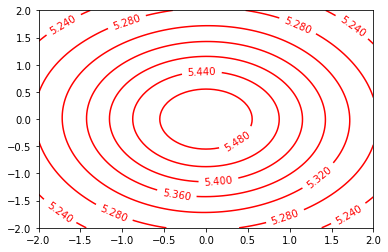

In [10]:
# plotting
from matplotlib.lines import Line2D
h1=plt.contour(Bx,By,0.5*abs(upjzup-downjzdown),colors='r')
plt.clabel(h1, inline=1, fontsize=10)
plt.show()

In [ ]:
def func(R, *p):
    """Polynomial fitting function."""
    if len(p)%2!=0:
        raise Exception("Number of arguments must be even.")

    x = R[0:81]
    y = R[81:]
    x,y = np.meshgrid(x,y)
    
    g = np.polyval(p[int(len(p)/2):], x) * np.polyval(p[:int(len(p)/2)], y)
    
    #g = (p0 + p1*x + p2*y + p3*z + p4*x*y + p5*x*z + p6*y*z + p7*x**2 + p8*y**2 +
    #     p9*z**2 + p10*x**3 + p11*y**3 + p12*z**3 + p13*x**2*y + p14*x**2*z + p15*y**2*x + p16*y**2*z
    #     + p17*z**2*x + p18*z**2*y + p19*x*y*z)
    return g.ravel()

In [ ]:
# fitting procedure using func()

from scipy import optimize

x_data=np.concatenate((Bx, By))
y_data=0.5*abs(upjzup-downjzdown).T.ravel()
p0=[ 1, 1, 1, 1, 1, 1, 1, 1 ]
params, params_covariance = optimize.curve_fit(func, x_data, y_data, p0=p0)

print(params)
# calculate R^2
residuals = y_data.ravel() - func(x_data, *params)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared = 1 - (ss_res / ss_tot)
print('R^2 (%s)=%s'%(func.__name__,str(r_squared)))

#plt.plot(x_data, func(x_data, *params), label=func.__name__)

In [ ]:
# plot fitted function and original data

from matplotlib.lines import Line2D

plt.figure(figsize=(10,10))
#data
h1 = plt.contour(Bx,By,0.5*abs(upjzup-downjzdown).T,colors='r')
#fit
h2 = plt.contour(Bx,By,func(x_data,*params).reshape(len(Bx),len(By)),colors='b')

custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]

plt.gca().legend(custom_lines, ['data', 'fit'])

plt.clabel(h1, inline=1, fontsize=10)     
plt.clabel(h2, inline=1, fontsize=10)
# plt.text(1.05,.95,'Bz=%1.4f'%Bz[index])
plt.xlabel('Bx')
plt.ylabel('By')
# plt.gcf().savefig('fit.png')
plt.show()

## Saving the data created on a grid of (B<sub>x</sub>, B<sub>y</sub>) to be used in the simulation by interpolating in between the grid values
The procedure includes generating the data for some value of meanBx (change the value +0.0 in cell \[26\]), and following the cells below

In [35]:
data=np.broadcast_to(0.5*abs(upjzup-downjzdown),(2,81,81))

In [ ]:
import os
import sys
def write_to_file(name, data, Bx, By, Bz):
    abs_file_path = name + '.txt'
    with open(abs_file_path, 'w') as outfile:
        # I'm writing a header here just for the sake of readability
        # Any line starting with "#" will be ignored by numpy.loadtxt
        outfile.write('# {0}\n'.format(data.shape))
        outfile.write('# Bz: %s\n'%np.array2string(Bz,threshold=sys.maxsize,max_line_width=np.nan,separator=','))
        outfile.write('# By: %s\n'%np.array2string(By,threshold=sys.maxsize,max_line_width=np.nan,separator=','))
        outfile.write('# Bx: %s\n'%np.array2string(Bx,threshold=sys.maxsize,max_line_width=np.nan,separator=','))
        # Iterating through a ndimensional array produces slices along
        # the last axis. This is equivalent to data[i,:,:] in this case
        for data_slice in data:

            # The formatting string indicates that I'm writing out
            # the values in left-justified columns 7 characters in width
            # with 2 decimal places.  
            np.savetxt(outfile, data_slice, fmt='%-7.8f')

            # Writing out a break to indicate different slices...
            outfile.write('# New Bz slice\n')


In [ ]:
write_to_file('magnetic_moment_up_arr_2.00_chak', data, Bx, By, np.array([-2.,2.]))

## Plot S<sub>z</sub><sup>2</sup>, T<sub>c</sub> and C<sub>zz</sub> vs. H<sub>x</sub>
Plot the magnetic moment calculated separately, the magnetic moment calculated during the simulation, T<sub>c</sub> and C<sub>zz</sub> all rescaled to have the same value at (H<sub>x</sub>=0) versus H<sub>x</sub>.  
1. `Czz.npz` is the one derived by Chakraborty et al. \[1\] and is created by this notebook
2. `Czz2.npz` is "our" version, where an effective longitudinal field is added for each value of the transverse field, and is created by the notebook `Magnetic moment and Energy - 3D fit & plot slices.ipynb`
3. `Czz3.npz` is the same as 2 but with hf interactions. not plotted.

In [11]:
from scipy.interpolate import interpn

In [12]:
points = (Bx, By)
values = 0.5*abs(upjzup-downjzdown).T
point = np.array([0,0.2])
print(interpn(points, values, point, method='splinef2d'))

[5.50673751]


In [ ]:
np.savez('Czz.npz',Bx,0.5*abs(upjzup-downjzdown))

In [45]:
loaded=np.load('Czz2.npz')
magnetic_moment_up_arr=loaded['arr_3']
Bx3=loaded['arr_0']
By3=loaded['arr_1']
Bz3=loaded['arr_2']

In [44]:
loaded3=np.load('Czz3.npz')
magnetic_moment_up_arr3=loaded3['arr_3']
Bx3=loaded3['arr_0']
By3=loaded3['arr_1']
Bz3=loaded3['arr_2']

FileNotFoundError: [Errno 2] No such file or directory: 'Czz3.npz'

In [46]:
BzIndex=(np.abs(np.array(Bz3) - 0.0)).argmin()
ByIndex=(np.abs(np.array(By3) - 0.0)).argmin()
# BzIndex=40
# ByIndex=40
print(BzIndex)
print(ByIndex)

39
39


In [ ]:
Bz3[BzIndex]

In [ ]:
magnetic_moment_up_arr3[40,40,40]*=-1

In [ ]:
%matplotlib qt

In [ ]:
(0.5*abs(upjzup-downjzdown)[40,:])**2

C:\WPy64-3770\python-3.7.7.amd64\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


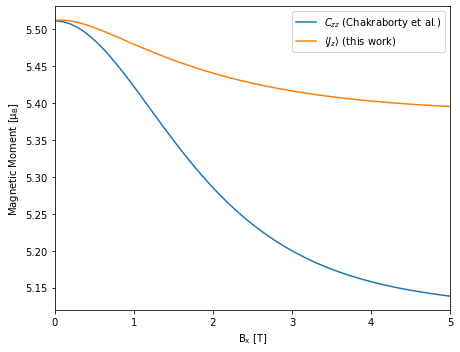

In [50]:
plt.close()
plt.figure(figsize=(6.5,5))
plt.plot(Bx,(0.5*abs(upjzup-downjzdown)[40,:]),label=r'$C_{zz}$ (Chakraborty et al.)')
plt.plot(Bx3,magnetic_moment_up_arr[BzIndex,ByIndex,:],label=r'$\langle J_z \rangle$ (this work)')
# plt.plot(Bx3,magnetic_moment_up_arr3[40,40,:],label='Ours2')
plt.xlim(0,5)
# plt.ylim(0,5.55)
plt.legend()
plt.ylabel('Magnetic Moment [$\\rm{\\mu_B}$]')
plt.xlabel('$\\rm{B_x\ [T]}$')
plt.tight_layout()
plt.gcf().savefig('figures/mag_moment_vs_Bx.pdf',format='pdf')
# plt.show()

In [5]:
scale_charkaborty = (0.5*abs(upjzup-downjzdown)[40,40])**2 / Chakraborty_hf_x[-1]
scale_ronnow = (0.5*abs(upjzup-downjzdown)[40,44])**2 / T[1]
scale_res_wo4 = (0.5*abs(upjzup-downjzdown)[40,44])**2 / res_wo4[0,0]

NameError: name 'upjzup' is not defined

In [6]:
Chakraborty_hf_x, Chakraborty_hf_y = sort(np.genfromtxt(r'data\Chakraborty_hf.txt',unpack=True))
plt.plot(Chakraborty_hf_y, scale_charkaborty*Chakraborty_hf_x, 's', fillstyle='none', label='QMC (Chakraborty et al. [2])', mew=2,ms=10, clip_on=False)

In [ ]:
T, ronnow_exp = sort(np.genfromtxt(r'data\Babkevich_exp.txt',unpack=True),sort_by_y=True)
plt.plot(ronnow_exp, scale_ronnow*T ,marker='>',mec='indianred',mew=2,ms=10,mfc='none',linestyle='none',label='Experimant (compiled by Babkevich et al. [5])',clip_on=False)

In [ ]:
our_mc = np.load(r'data\data.npz',allow_pickle=True)
# plt.plot(ronnow_exp, scale_ronnow*T ,marker='>',mec='indianred',mew=2,ms=10,mfc='none',linestyle='none',label='Experimant (compiled by Babkevich et al. [5])',clip_on=False)

In [ ]:
plt.scatter(our_mc['arr_0'].T[6],our_mc['arr_0'].T[0], label='$<J_z^2>$, mechanism off')

In [ ]:
our_mc_wo = np.load(r'data\data_wo.npz',allow_pickle=True)
# plt.plot(ronnow_exp, scale_ronnow*T ,marker='>',mec='indianred',mew=2,ms=10,mfc='none',linestyle='none',label='Experimant (compiled by Babkevich et al. [5])',clip_on=False)

In [ ]:
plt.scatter(our_mc_wo['arr_0'].T[6],our_mc_wo['arr_0'].T[0], label='$<J_z^2>$, mechanism off, const')

In [ ]:
our_mc_w = np.load(r'data\data_w.npz',allow_pickle=True)
plt.scatter(our_mc_w['arr_0'].T[6],((0.5*abs(upjzup-downjzdown)[40,40])**2 / our_mc_w['arr_0'].T[0][0])*our_mc_w['arr_0'].T[0], label='$<J_z^2>$, mechanism on, const')

In [ ]:
plt.plot(res_wo4[:,2],scale_res_wo4*res_wo4[:,0],marker='x',linestyle='none', mew=2,ms=10, label='ODD terms excluded ($J_{ex}=3.91$ mK), L=5,6,7', clip_on=False)
plt.plot(res_w3[:,2],((0.5*abs(upjzup-downjzdown)[40,40])**2 / res_w3[0,0])*res_w3[:,0],marker='x',linestyle='none', mew=2,ms=10, label='ODD terms included ($J_{ex}=1.16$ mK), const. moment', clip_on=False)
plt.plot(res_wo3[:,2],((0.5*abs(upjzup-downjzdown)[40,40])**2 / res_wo3[0,0])*res_wo3[:,0],marker='x',linestyle='none', mew=2,ms=10, label='ODD terms excluded ($J_{ex}=1.16$ mK), const. moment', clip_on=False)

In [ ]:
plt.xlim(0,2)
plt.ylim(15,35)
plt.xlabel('$B_x$')
plt.ylabel(r'$\langle J_z^2 \rangle $')
plt.legend()

In [ ]:
plt.gcf().savefig('S_z2_vs_Hx.pdf')

Some $T_c$ values from MC simulations:

In [ ]:
res_wo4=np.array([[1.5096135538920437, 0.0005109413850920518, 0.0],
                    [1.5073050811041786, 0.000445658320260803, 0.3],
                    [1.4814976304405443, 0.0004110096135758716, 0.6],
                    [1.4497300158513422, 0.0005158071024299779, 1.0],
                    [1.2569411136094195, 0.00033478958949719514, 1.5]])

In [ ]:
res_w3=np.array([[1.5559052010018908, 0.000332532186120921, 0.0],
                [1.5479361637185762, 0.00029061385640320823, 0.3],
                [1.53414671227904, 0.0002879103947500188, 0.6],
                [1.5050706238379528, 0.00046136481898499595, 1.0],
                [1.4517850722328578, 0.0002808759623497347, 1.5],
                [1.400964536947133, 0.0003757495990619571, 2.0]])

In [ ]:
res_wo3=np.array([[1.7626170500334353, 0.0003453704452627634, 0.0],
                    [1.761901735564787, 0.00026504420324123155, 0.3],
                    [1.7498711316194884, 0.0003069218719886814, 0.6],
                    [1.7289585263359022, 0.0003222821586886707, 1.0],
                    [1.6968147808099938, 0.0003554835230606231, 1.5],
                    [1.6544695375845413, 0.0004810994346332488, 2.0]])

In [3]:
def sort(lst, sort_by_y=False):
    if len(lst)==3:
        x, y, err = lst
    elif len(lst)==2:
        x, y = lst
        
    if not sort_by_y:
        p = x.argsort()
    else:
        p = y.argsort()
    x=x[p]
    y=y[p]
    if len(lst)==3:
        err=err[p]
    
    if len(lst)==3:
        return (x,y,err)
    elif len(lst)==2:
        return (x,y)